# FMCW Radar 103 - AoA

> In FMCW MIMO (multiple TX, multiple RX antennas) radar, the Angle of Arrival is computed from the phase difference measured at each antenna.

Status:
* Minimum Reproducible Example for 1 target multiple angles, 2 RX antennas and calculation of the Angle of Arrival
* Shows how to compute Bartlet and Capon with code
* Back-up code also looks at using FFT and cross-correlation (not yet finished)

Results:
* shows that Barlett ,for 6 elements, is limited to 8.5 degrees and CAPON goes done to 2.5 degrees all other parameters equivalent.
* compares code to existing pyargus library (similar results).

Next:
* instead of implicit compute of Rxx from steering vector (Eq 7.21 below) , compute its estimates with ADC samples (Eq RXX_1) and add this into radar signal chain

History:
* 2023-01-02: Added 2D FFT AoA, CAPON and Bartlet <div>(
<img src="https://upload.wikimedia.org/wikipedia/commons/1/15/Ambox_warning_pn.svg" width="32"/> see code cell for <font color='red'> warning </font> about same range bin) </div>
* 2022-12-16: Moved 2 RX antennas MRE to fore-front.
* 2022-12-14: added MRE for single target 2 antennas
* 2022-10-28: adding investigations with Pyargus on resolution as function elements in ULA with Capon vs Bartlet
* 2022-10-22: fixed Bartlett and Capon code to allow for any number of RX elements

Next:

* click to access other workbooks:
  * [FMCW 101 - Range and Speed](https://colab.research.google.com/gist/matt-chv/bdd8b835c5cb7e739bb8b68d00257690/fmcw-radar-101.ipynb): Measure distance and speed for FMCW radar.
  * [FMCW 102 - CFAR](https://colab.research.google.com/gist/matt-chv/33e98a23d4b9d90dd27c1bf7f0a54781/fmcw-radar-102-cfar.ipynb) : CFAR or how to detect objects of interest from range FFT.
  * [FMCW 103 - AoA](https://colab.research.google.com/gist/matt-chv/d81f7e2166009a623a36781a0773ae47/fmcw-radar-103-aoa.ipynb) : angle of arrival (CAPON vs Bartlett)
  * [FMCW 104 - increased resolution vs FFT bin](https://colab.research.google.com/gist/matt-chv/0b25dbc4673f2d7d63804cc6241643b9/fmcw-radar-104-1-fft-freq-estimation.ipynb)increase accuracy option compared to standard FFT.
  * Also available on github as gist for forking:
    * [fmcw 101](https://gist.github.com/matt-chv/bdd8b835c5cb7e739bb8b68d00257690)
    * [fmcw 102](https://gist.github.com/matt-chv/33e98a23d4b9d90dd27c1bf7f0a54781)
    * ...

Related ressources:

## AoA Maths

## Minimum Reproductible Examples

## Phase based AoA estimate

In [ ]:
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
from scipy.fft import fft

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 200e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
T = arange(0, n_samples*ts+ts, ts)

for theta in [-180/3, -180/6, -180/10, 0, 180/10, 180/6, 180/3]:
    target = (4*sin(theta/180*pi), 4*cos(theta/180*pi),0)

    Antennas_RXs = [(i*lambda0_max/2,0,0) for i in range(n_rx)]

    phases = []
    i_peaks = []
    for antenna_rx in Antennas_RXs:
        tx_x, tx_y, tx_z = antenna_tx
        rx_x, rx_y, rx_z = antenna_rx
        t_x, t_y, t_z = target
        distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
        distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
        f_if = 2*k*Distance/c
        assert f_if < 1/ts/2
        YIF = y_IF(f0_min, k,T, antenna_tx, antenna_rx, target)
        FT = fft(YIF)
        MAG = abs(FT)[0:int(n_samples/2)]
        ANG = angle(FT)[0:int(n_samples/2)]

        # now find the peak
        amplitude_peak = sorted(MAG, reverse = True)[0]
        i_peak = list(MAG).index(amplitude_peak)
        if not i_peaks:
            i_peaks.append(i_peak)
        else:
            try:
                assert i_peak in i_peaks
            except:
            # exit now as we don't have the logic to track across range bins
                print("bin range change")
                break
        phases.append(ANG[0:int(n_samples/2)][i_peak])
        f_peak = i_peak * 1/ts / n_samples
        d2 = f_peak*c/2/k
        dfixed = 0

    delta_phase = (phases[0]-phases[1])  #/len(phases)
    if delta_phase/pi>1:
        theta_calc = arcsin(delta_phase/pi -2)*180/pi
        print(f"theta: {theta:.2g}, calculated_p: {theta_calc:.2g}")
    elif delta_phase/pi<-1:
        theta_calc = arcsin(delta_phase/pi % +2)*180/pi
        print(f"theta: {theta:.2g}, calculated_m: {theta_calc:.2g}")
    else:
        theta_calc = arcsin(delta_phase/pi)*180/pi
        print(f"theta: {theta:.2g}, calculated: {theta_calc:.2g}")

theta: -60, calculated: -62
theta: -30, calculated: -31
theta: -18, calculated: -18
theta: 0, calculated: -0.018
theta: 18, calculated: 18
theta: 30, calculated: 31
theta: 60, calculated: 62


## FFT based AoA

Text(0.5, 1.0, 'AoA-Range 2D FFT')

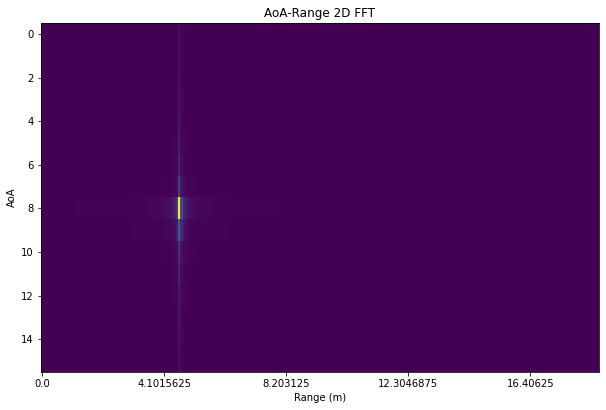

In [ ]:
# single target FFT AoA MRE
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan, zeros
from scipy.fft import fft, fft2
import matplotlib.pyplot as plt

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 32
Distance = 10
k = 200e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
T = arange(0, n_samples*ts, ts)

#for theta in [-180/3, -180/6, -180/10, 0, 180/10, 180/6, 180/3]:
theta = -180/6
target = (4*tan(theta/180*pi),4,0)

Antennas_RXs = [(i*lambda0_max/2,0,0) for i in range(n_rx)]

phases = []
i_peaks = []
cube2D = zeros((n_rx, n_samples))
for i, antenna_rx_i in enumerate(Antennas_RXs):
    tx_x, tx_y, tx_z = antenna_tx
    rx_x, rx_y, rx_z = antenna_rx_i
    t_x, t_y, t_z = target
    distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
    distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
    f_if = 2*k*Distance/c
    assert f_if < 1/ts/2
    YIFi = y_IF(f0_min, k, T, antenna_tx, antenna_rx_i, target)
    cube2D[i, :] = YIFi

Z_fft2 = abs(fft2(cube2D))
Data_fft2 = Z_fft2[0:n_rx//2,0:n_samples//2]

# change scale for 2D plot to display range and velocity values
# https://stackoverflow.com/a/53746824
# range formula
ranges = arange(0, fs*c/2/k, fs*c/2/k/n_samples)
no_labels = 10 # how many labels to see on axis x
step_x = int(n_samples / (no_labels - 1)) # step between consecutive labels
x_positions = arange(0, n_samples, step_x) # pixel count at label position
x_labels = ranges[::step_x] # labels you want to see
plt.xticks(x_positions, x_labels)

# angle of arrival
# angles = arange(-90, 90, 1)
# no_labels_y = 5 # how many labels to see on axis y
# step_y = int(n_chirps / (no_labels_y - 1)) # step between consecutive labels
# y_positions = arange(0, n_chirps, step_y) # pixel count at label position
# y_labels = speeds[::step_y] # labels you want to see
# plt.yticks(y_positions, y_labels)

# adding aspect=10 to have a more readable image
# since we have ~512 samples
# and only ~16 antennas
plt.imshow(Data_fft2, interpolation='nearest', aspect=10)

# plt.rcParams["figure.figsize"] = (10,100)
plt.xlabel("Range (m)")
plt.ylabel("AoA")
plt.title('AoA-Range 2D FFT')


Text(0.5, 1.0, 'AoA-Range 2D FFT')

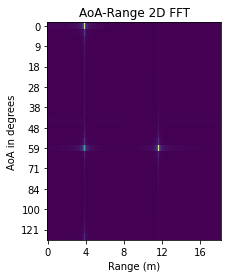

In [ ]:
# 3 targets FFT AoA MRE
from numpy import abs ,angle, arange, arcsin, cos, pi, sin, sqrt, tan, zeros
from scipy.fft import fft, fft2
import matplotlib.pyplot as plt

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 32
k = 200e12
n_samples = 512
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
T = arange(0, n_samples*ts, ts)

Antennas_RXs = [(i*lambda0_max/2,0,0) for i in range(n_rx)]

phases = []
i_peaks = []
cube2D = zeros((n_rx, n_samples))

d0, theta0 = 4, 0
target0 = (d0*sin(theta0/180*pi),d0*cos(theta0/180*pi),0)
t_x, t_y, t_z = target0

d1, theta1 = 4, 180/3
target1 = (d1*sin(theta1/180*pi),d1*cos(theta1/180*pi),0)
t_x, t_y, t_z = target1

d2, theta2 = 12, 180/3
target2 = (d2*sin(theta2/180*pi),d2*cos(theta2/180*pi),0)

for i, antenna_rx_i in enumerate(Antennas_RXs):
    tx_x, tx_y, tx_z = antenna_tx
    rx_x, rx_y, rx_z = antenna_rx_i

    distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
    distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
    f_if = 2*k*distance/c
    assert f_if < 1/ts/2
    YIFi0 = y_IF(f0_min, k, T, antenna_tx, antenna_rx_i, target0)
    YIFi1 = y_IF(f0_min, k, T, antenna_tx, antenna_rx_i, target1)
    YIFi2 = y_IF(f0_min, k, T, antenna_tx, antenna_rx_i, target2)

    YIFi = YIFi0 + YIFi1 + YIFi2

    cube2D[i, :] = YIFi

Z_fft2 = abs(fft2(cube2D))
Data_fft2 = Z_fft2[0:n_rx,0:n_samples//2]

# change scale for 2D plot to display range and velocity values
# https://stackoverflow.com/a/53746824
# range formula
ranges = arange(0, fs*c/2/k, fs*c/2/k/n_samples)
# convert to int for ease of dispaly on x_axis
ranges = ranges.astype(int)
no_labels = 10 # how many labels to see on axis x
step_x = int(n_samples / (no_labels - 1)) # step between consecutive labels
x_positions = arange(0, n_samples, step_x) # pixel count at label position
x_labels = ranges[::step_x] # labels you want to see
plt.xticks(x_positions, x_labels)

# angle of arrival labels
# non linear as we have arcsin to convert phase delta to AoA
phases = arange(0, 1, 1/n_rx)
angles = arcsin(phases)*100
angles = angles.astype(int)
n_angles = len(angles)
no_labels_y = 10 # how many labels to see on axis y
step_y = int(n_rx / (no_labels_y - 1)) # step between consecutive labels
y_positions = arange(0, n_rx, step_y) # pixel count at label position
y_labels = angles[::step_y] # labels you want to see
plt.yticks(y_positions, y_labels)

# adding aspect=10 to have a more readable image
# since we have ~512 samples
# and only ~16 antennas
plt.imshow(Data_fft2, interpolation='nearest', aspect=10)

# plt.rcParams["figure.figsize"] = (10,100)
plt.xlabel("Range (m)")
plt.ylabel("AoA in degrees")
plt.title('AoA-Range 2D FFT')

## Bartlet based AoA

* Eq RXX_1

$$ R_{xx} \approx \frac{1}{N} \cdot \displaystyle\sum_{k=0}^{n} X(t) \cdot X^H(t) $$
[source Eq 14.](https://www.mdpi.com/2411-5134/4/3/43/pdf)
Where X(t) is
$$ X(t) =
\begin{pmatrix}
 x_1(t_1) & x_1(t_2) & \cdots & x_1(t_n) \\
 x_2(t_1) & x_2(t_2) & \cdots & x_2(t_n) \\
\vdots & \vdots & \ddots & \vdots \\
 x_M(t_1) & x_M(t_2) & \cdots & x_M(t_n)
\end{pmatrix} $$

and 7.22:

* PB(θ) = /aH(θ) * Rxx * /a(θ)

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/1/15/Ambox_warning_pn.svg" width="128"/>
</div>

The non-correlation constraint for the correlation matrix, implies that the targets _cannot_ be in the same range bin !!


Text(0.5, 0, 'AoA in degrees')

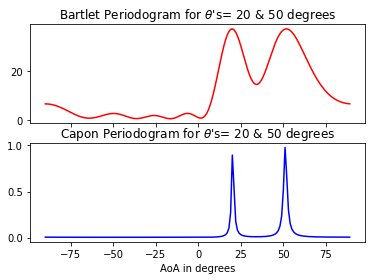

In [ ]:
from numpy import arange, array, cos, column_stack, exp, identity, matrix, random, pi, sin, sqrt, zeros
import matplotlib.pyplot as plt

n_rx = 6
# M = n_rx
f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
k = 200e12
n_samples = 512
fs = 50e6
ts = 1/fs

def a(theta, M=n_rx):
    # a_theta is the steering vector - defined by the sensing array
    theta=theta/180*pi
    return array([exp(n*1j*pi*sin(theta)) for n in range(M)])

def R_est(Xs):
    n = Xs.shape[1]
    X = matrix(Xs)
    Rxx = X*X.H
    Rxx = Rxx/n
    return Rxx

def Rxx_expl(thetas,M=6,s2_n=0.1):
  """
  A: MxD matrix of steering vectors
  M: number of elements in array
  D: number of targets
    assumed: D<M
  Returns:
    Rxx_explicit: MxM matrix
  """
  Rnn = s2_n**2*identity(M)
  simple = True
  if simple:
    Rss=matrix('1 0 ; 0 1')
    theta1, theta2 = thetas
    A=matrix(column_stack((a(theta1,M=M), a(theta2,M=M))))
  else:
    Rss= matrix(identity(len(thetas)))
    A=matrix(column_stack((a(theta) for theta in thetas)))
    """
    for i, theta in enumerate(thetas):
      a_i = a(theta)
      A[:,i]=a_i
    A=matrix(A)
    """

  Rxx_explicit = A*Rss*A.H+Rnn
  return Rxx_explicit

def pb(theta,Rxx,M=n_rx):
  # pb: bartlett periodogram
  ath = matrix(a(theta,M))
  return matrix(a(theta,M)).T.H * Rxx * matrix(a(theta,M)).T

def pc(theta, Rxx, M=n_rx):
  # pc: capon periodogram
  return 1/(matrix(a(theta,M)).T.H * Rxx.I * matrix(a(theta,M)).T)

def y_IF_complex(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
    """ See prior instances for comments """
    tx_x, tx_y, tx_z = antenna_tx
    rx_x, rx_y, rx_z = antenna_rx
    t_x, t_y, t_z = target
    distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
    distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
    # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
    delta = distance/v
    # YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2)) # +\
        # 1j*sin(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
    YIF = exp(-2*pi*1j*((f0_min * delta + slope * delta * T + slope * delta**2)))
    return YIF



antenna_tx = (-lambda0_max/2,0,0)
antenna_tx = (0,0,0)
T = arange(0, n_samples*ts, ts)

d0, theta0 = 4, 20
target0 = (d0*sin(theta0/180*pi), d0*cos(theta0/180*pi),0)
t_x, t_y, t_z = target0

d1, theta1 = 5, 50
target1 = (d1*sin(theta1/180*pi), d1*cos(theta1/180*pi),0)
t_x, t_y, t_z = target1

noise_sigma = 0.1

Antennas_RXs = [((i)*lambda0_max/2,0,0) for i in range(n_rx)]

cube2D = zeros((n_rx, n_samples)).astype(complex)

for i, antenna_rx_i in enumerate(Antennas_RXs):
    tx_x, tx_y, tx_z = antenna_tx
    rx_x, rx_y, rx_z = antenna_rx_i
    t_x, t_y, t_z = target0
    distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
    distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
    f_if = 2*k*distance/c
    assert f_if < 1/ts/2
    YIFi0 = y_IF_complex(f0_min, k, T, antenna_tx, antenna_rx_i, target0) + random.normal(0,noise_sigma,n_samples)
    YIFi1 = y_IF_complex(f0_min, k, T, antenna_tx, antenna_rx_i, target1) + random.normal(0,noise_sigma,n_samples)

    YIFi = YIFi0 + YIFi1
    cube2D[i, :] = YIFi

Rxx = R_est(cube2D)
# can be interesting to compare to `theoretical` cross correlation
# for instance it shows that when in the same range bin the two matrices
# don't match
# R = Rxx_expl((theta0, theta1), M=n_rx, s2_n = noise_sigma)

theta = arange(-90,90,1)
PB=[abs(pb(th,Rxx,n_rx)).item(0) for th in theta]
PC=[abs(pc(th,Rxx,n_rx)).item(0) for th in theta]

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.title.set_text(r"Bartlet Periodogram for $ \theta$'s"+f"= {theta0} & {theta1} degrees")
ax1.plot(theta, PB, 'r')
ax2.title.set_text(r"Capon Periodogram for $ \theta $'s"+f"= {theta0} & {theta1} degrees")
ax2.plot(theta, PC, 'b')
ax2.set_xlabel('AoA in degrees')

## Capon based AoA

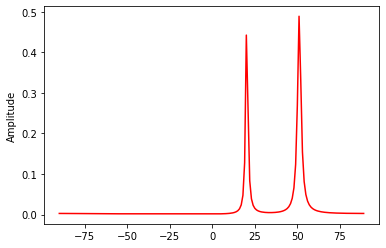

In [ ]:
plt.figure()
plt.plot(theta, PC, 'r')
plt.ylabel('Amplitude')
plt.show()

## Back-up

### imports

In [ ]:
#imports
from numpy import abs,angle,arange,array, linspace,matrix, pi,sin,cos, exp
from numpy import column_stack, identity
#import scipy.fftpack
from scipy.fftpack import fft, fftshift, fftfreq
import matplotlib.pyplot as plt

print("imports done")

imports done


### defines

In [ ]:
# defines

def fmcw_fft(signal,time,Fs,plot_fft=True,plot_abs_nphase=True,minf=0,maxf=1,Npeaks=1):
  """main function for fmcw FFT related math
  Parameters:
  -----------
  signal: numpy ndarray
    the signal whose FFT we are interested int
  time: numpy ndarray
    time stamps at which we sampled the signal
  Fs: float
    sampling frequency
  plot_fft: bool
    if we show FFT or not
  plot_abs_n_phase: bool
    if we look at magnitude or phase
  minf: float
    zoom inside FFT (between 0 and 1.0)
  maxf: float
    zoom inside FFT (between 0 and 1.0)
  Returns:
  --------
  None if plot_fft==True
  freq or phase for which magnitude is max for FFT
  """
  N2 = int(len(signal)/2)
  FFT = fft(signal) #/len(signal)    #normalise amplitude
  FFT = FFT[range(int(len(signal)/2))]
  tpCount     = len(signal)
  values      = arange(int(tpCount/2))
  timePeriod  = tpCount/Fs
  frequencies = linspace(0.0, Fs/(2), N2) #values/timePeriod

  magnitude = abs(FFT)
  phase = angle(FFT)

  #peak = max(list(magnitude))
  #fpeak = list(magnitude).index(peak)
  sorted_magnitude = sorted(magnitude,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks]
  fpeaks = [list(magnitude).index(peak) for peak in sorted_magnitude]


  if plot_fft:
    #either we plot the fft or we return the peak position

    if plot_abs_nphase:
      #either we plot amplitude or phase
      #added provision for zooming on certain section of the FFT
      plt.plot(frequencies[int(len(frequencies)*minf):int(len(frequencies)*maxf)],
              magnitude[int(len(frequencies)*minf):int(len(frequencies)*maxf)])
      plt.title('FFT')
      plt.xlabel('Freq (Hz)')
      plt.ylabel('X(t)')
    else:
      plt.plot(frequencies[int(len(frequencies)*minf):int(len(frequencies)*maxf)],
              phase[int(len(frequencies)*minf):int(len(frequencies)*maxf)])
      plt.title('FFT (phase)')
      plt.xlabel('Freq (Hz)')
      plt.ylabel('phase')
  else:
    if plot_abs_nphase:
      return [frequencies[fpeak] for fpeak in fpeaks]
      #return frequencies[fpeak]
    else:
      #return phase[fpeak]
      return [phase[fpeak] for fpeak in fpeaks]

In [ ]:
start = 0

#R0: distance between radar and target in meters (m)
Distance=10
R0 = Distance
# c: speed of light
c=3e8
# Chirp_Slope: chirp ramp 10 MHz/us = 10e12
Chirp_Slope=10e12
S = Chirp_Slope
# target object speed in m/s
v=1
#60GHz = 0.005 m
#should be lambda at end of chirp, keeping 5mm to simplify
fmin = 60e9 #60GHz
lambda_max=0.005
tof = 2*Distance/c
# frequency of IF signal
f_if = 2*Chirp_Slope*Distance/c
N=1024
step  = 1/f_if/4096
stop  = 5/f_if

stop = 5/f_if
step = stop/N


N=2048
t = None
y0, y1 = None, None
Y1, Y1 = None, None
#R0=33
f_if0 = f_if
Ts = 1/f_if0/512
Fs = 1/Ts
N=1024
delta_2_chirps=1.2e-6

def fmcw_if(t,delta_T=1e-6,vt=0,dt=10,show_phase = False):
    """ generates the IF signal and returns key values for debug
    Parameters:
      t: numpy array
      vt: float
      dt: float
      show_phase: Bool
    Returns:
      y_t: numpy array (if show_phase == False)
      phase: float (if show_phase == True
    """
    phase_count = 2*(dt+vt*delta_T)*fmin/c
    phase = 2*pi*phase_count
    freq_if = Chirp_Slope*2*(dt+vt*delta_T)/c
    y_t = sin(2*pi*freq_if*t+phase)
    if show_phase:
        return phase
    else:
        return y_t

for Distance in [10,20]:
  for v in [0.1e3, 0.5e3, 0.2e3]:

      # ensure no phase ambiguity
      assert v*4*pi*delta_2_chirps/lambda_max<pi/2
      # ensure Nyquist
      assert f_if0<Fs/2

      t = linspace(0.0, N*Ts, N)

      # get first chirp if signal
      y0 = fmcw_if(t,delta_T=0,vt=v,dt=Distance)
      # get 2d chirp if signal
      y1 = fmcw_if(t,delta_T=delta_2_chirps,vt=v,dt=Distance)

      # Estimate distance: get frequency of peak
      f0 = fmcw_fft(y0,t,1/Ts,plot_fft=False,plot_abs_nphase=True)
      f0=f0[0]
      ## f0 = s* 2 * d / c => d = f0* c/ 2/s
      R0_est = f0*c/2/S
      print(f"Estimated Distance: {R0_est:.2g} real distance was {Distance:.2g}")

      #get the phase at target frequency bin for first chirp
      ph0 = fmcw_fft(y0,t,1/Ts,plot_fft=False,plot_abs_nphase=False)
      ph0=ph0[0]
      #get the phase at target frequency bin for second chirp
      ph1 = fmcw_fft(y1,t,1/Ts,plot_fft=False,plot_abs_nphase=False)
      ph1=ph1[0]

      v_est = lambda_max*(ph1-ph0)/(4*pi*delta_2_chirps)
      print(f"Estimated speed: {v_est:.2g} real speed was {v:.2g}")


Estimated Distance: 10 real distance was 10
Estimated speed: 1e+02 real speed was 1e+02
Estimated Distance: 10 real distance was 10
Estimated speed: 5e+02 real speed was 5e+02
Estimated Distance: 10 real distance was 10
Estimated speed: 2e+02 real speed was 2e+02
Estimated Distance: 20 real distance was 20
Estimated speed: 1e+02 real speed was 1e+02
Estimated Distance: 20 real distance was 20
Estimated speed: 5e+02 real speed was 5e+02
Estimated Distance: 20 real distance was 20
Estimated speed: 2e+02 real speed was 2e+02


In [ ]:

from numpy import sqrt, arccos, arctan, sign, mean, unwrap

def fmcw_if_target(t,rx_antenna,tx_antenna,target,delta_T=1e-6,): #vt=0,dt=10,show_phase = False):
    """ generates the IF signal and returns key values for debug
    Parameters:
      t: numpy array
      rx_antenna: t-uple of float
      target: t-uple of float
      delta_T: float
        time offset between current chirp and first chirp of frame
    Returns:
      y_t: numpy array (if show_phase == False)
      phase: float (if show_phase == True
    """
    dt = distance(target,tx_antenna,rx_antenna)
    vt = 0

    phase_count = 2*(dt+vt*delta_T)*fmin/c
    phase = 2*pi*phase_count
    freq_if = Chirp_Slope*2*(dt+vt*delta_T)/c
    y_t = sin(2*pi*freq_if*t+phase)
    return y_t

def distance(target,tx,rx):
  xt,yt,zt = target
  xrx,yrx,zrx = rx
  xtx,ytx,ztx = tx
  d = sqrt((xt-xrx)**2+(yt-yrx)**2+(zt-zrx)**2+\
           (xt-xtx)**2+(yt-ytx)**2+(zt-ztx)**2)
  return d

def _unwrap(X0,debug=False):

  X1 = [X0[0]]
  for x in X0[1:]:

    if abs(X1[-1]-x)>250:
      x1 = x+sign(X1[-1])*sign(x)*360
    elif abs(X1[-1]-x)>90:
      #if we cross 0 only add 180
      if sign(X1[-1])==sign(x):
        x1 = x+sign(X1[-1])*sign(x)*180
      else:
        x1 = x+sign(X1[-1])*180

    else:
      x1=x
    if debug:
      print(92,x,x1,abs(X1[-1]-x))
    X1.append(x1)
  return X1

AoA 1 45.0
AoA target_0 0.0
AoA target_1 12.528807709151511
AoA target_2 48.012787504183336
116 5.026548245743669
600000.0


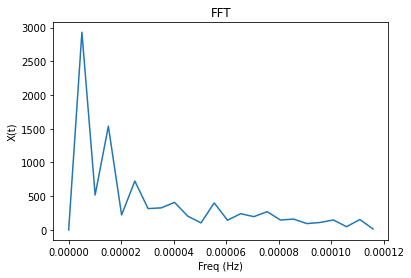

In [ ]:
tx_antenna = [(0,0,0)]
NRX = 500
d=lambda_max/2
X_rx = [(n-NRX/2)* d for n in range(1,NRX)]
rx_antennas = [(x,0,0) for x in X_rx]
Z0=0.9*R0
X_step = 10
offset = 3
NTargets = 3
targets = [(offset+(n-int(NTargets/2))*X_step,0,Z0) for n in range(NTargets)]
targets = [(0,0,Z0),(2,0,Z0),(10,0,Z0)]

phases = []
aoa = []
#targets=[targets[1]]
#rx_antennas = [rx_antennas[0]]

#fmcw_if_new = fmcw_if_target
print("AoA 1",arctan(1)*180/pi)
for i,target in enumerate(targets):
  x,y,z = target
  print(f"AoA target_{i}",arctan(x/z)*180/pi)
for rx in rx_antennas:
  y=0
  for i,target in enumerate(targets):

    # ensure no phase ambiguity
    assert v*4*pi*delta_2_chirps/lambda_max<pi/2


    t = linspace(0.0, N*Ts, N)

    # get first chirp if signal
    Distance = distance(target,tx_antenna[0],rx)
    f_if0 = 2*Chirp_Slope*Distance/c
    # ensure Nyquist
    assert f_if0<Fs/2

    #y0 = fmcw_if(t,delta_T=0,vt=0,dt=Distance)
    y0 = fmcw_if_target(t,rx,tx_antenna[0],target,delta_T=0)
    # get 2d chirp if signal
    #y1 = fmcw_if(t,delta_T=delta_2_chirps,vt=v,dt=Distance)
    y+=y0
  # Estimate distance: get frequency of peak
  f0 = fmcw_fft(y,t,1/Ts,plot_fft=False,plot_abs_nphase=True)
  f0=f0[0]
  #_ = fmcw_fft(y0,t,1/Ts,plot_fft=True,plot_abs_nphase=True,maxf=0.3)
  assert f0<Fs/2
  ## f0 = s* 2 * d / c => d = f0* c/ 2/s
  R0_est = f0*c/2/S
  #print(f"Estimated Distance: {R0_est:.3g} real distance was {Distance:.3g}")
  #get the phase at target frequency bin for first chirp
  ph0 = fmcw_fft(y,t,1/Ts,plot_fft=False,plot_abs_nphase=False)
  ph0=ph0[0]
  aoa.append(ph0*180/pi)




P=0
if P==0:
  myd = False
else:
  myd=True
#_unwrap
#aoa = _unwrap(aoa[P:-1],debug=myd)
#print(len(aoa))
aoa = list(unwrap(aoa))
#print("a8",len(aoa))
X = [180*(n-NRX/2)/2/NRX for n in range(1,NRX)]
#X=X[P:-1]
#X = [180*(n-NRX/2)/2/NRX for n in range(1,P+1)]

maoa = mean(aoa)
#print(maoa)
aoa=[x-maoa for x in aoa]
if False:
  f, ax1 = plt.subplots(num=1, clear=True)
  ax1.plot(X,aoa,'xb')
else:
  fmcw_fft(aoa,X_rx,d,plot_fft=True,plot_abs_nphase=True,maxf=0.1)

#f.title('phase array')
#ax1.xlabel('X')
#ax1.ylabel('Y')
#phases.append(aoa)
#aoa=[]

#peak = min(aoa)
#fpeak = aoa.index(peak)
#print(peak,fpeak)

#  plt.plot(range(len(phases)),phases,'xb')
#  plt.title('phase array')
#  plt.xlabel('X')
#  plt.ylabel('Y')
print(116,2*pi/NRX/d)
print(12/.00002)

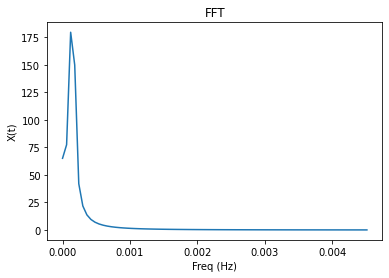

In [ ]:
N=512
TM=pi/2*10
t = linspace(0.0, TM, N)
y=sin(t)
#plt.plot(t,y)
f0 = fmcw_fft(y,t,TM/N,plot_fft=True,plot_abs_nphase=True,maxf=0.3)

## BARTLET in python

From
Smart Antennas
for Wireless
Communications
With MATLAB

Frank B. Gross, PhD
Senior Systems Engineer
Argon ST
Fairfax, Virginia

Example 7.5
Use MATLAB to plot the pseudo-spectrum using the Bartlett
estimate for an M = 6 element array. With element spacing d = λ/2, uncorrelated,
equal amplitude sources, (s1, s2), and σ2
n = .1, and the two different
pairs of arrival angles given by ±10◦ and ±5◦, assume ergodicity.


### Solution
Solution From the information given we can find the following:
* /s = [1 1]

* a¯(θ) = [1 e jπ sin θ · · · e j5π sin θ ]T
* A = [/a(θ1) /a(θ2)]
* Rss = [[1 0] [0 1]]

Note: Rss = [[1 0] [01]] is the DxD (with D number of sources) source correlation matrix - assumption is that all signals are not correlated.

Applying Eq. (7.21) we can find Rxx for both sets of angles. Substituting Rxx
into Eq. (7.22) and usingMATLAB,we can plot the pseudospectrum as shown
in Figs. 7.2a and b.

Where 7.21 is:

* Rxx = A * Rss * AH + Rnn

or implicitly

* Eq RXX_1

$$ R_{xx} \approx \frac{1}{N} \cdot \displaystyle\sum_{k=0}^{n} X(t) \cdot X^H(t) $$
[source Eq 14.](https://www.mdpi.com/2411-5134/4/3/43/pdf)
Where X(t) is
$$ X(t) =
\begin{pmatrix}
 x_1(t_1) & x_1(t_2) & \cdots & x_1(t_n) \\
 x_2(t_1) & x_2(t_2) & \cdots & x_2(t_n) \\
\vdots & \vdots & \ddots & \vdots \\
 x_M(t_1) & x_M(t_2) & \cdots & x_M(t_n)
\end{pmatrix} $$

and 7.22:

* PB(θ) = /aH(θ) * Rxx * /a(θ)

[[2.01      +0.00000000e+00j 1.47618256-8.79346446e-01j
  0.45349966-8.37458879e-01j 0.00334958+8.17798235e-02j
  0.59732525+9.15343130e-01j 1.61315704+7.89961043e-01j]
 [1.47618256+8.79346446e-01j 2.01      -2.21956895e-17j
  1.47618256-8.79346446e-01j 0.45349966-8.37458879e-01j
  0.00334958+8.17798235e-02j 0.59732525+9.15343130e-01j]
 [0.45349966+8.37458879e-01j 1.47618256+8.79346446e-01j
  2.01      +1.99410676e-17j 1.47618256-8.79346446e-01j
  0.45349966-8.37458879e-01j 0.00334958+8.17798235e-02j]
 [0.00334958-8.17798235e-02j 0.45349966+8.37458879e-01j
  1.47618256+8.79346446e-01j 2.01      -4.69395873e-18j
  1.47618256-8.79346446e-01j 0.45349966-8.37458879e-01j]
 [0.59732525-9.15343130e-01j 0.00334958-8.17798235e-02j
  0.45349966+8.37458879e-01j 1.47618256+8.79346446e-01j
  2.01      +0.00000000e+00j 1.47618256-8.79346446e-01j]
 [1.61315704-7.89961043e-01j 0.59732525-9.15343130e-01j
  0.00334958-8.17798235e-02j 0.45349966+8.37458879e-01j
  1.47618256+8.79346446e-01j 2.01      +0.0

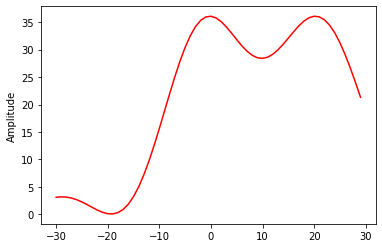

In [ ]:

def a(theta, M=6):
  # a_theta is the steering vector - defined by the sensing array
  theta=theta/180*pi
  return array([exp(n*1j*pi*sin(theta)) for n in range(M)])

def Rxx_expl(thetas,M=6,s2_n=0.1):
  """
  A: MxD matrix of steering vectors
  M: number of elements in array
  D: number of targets
    assumed: D<M
  Returns:
    Rxx_explicit: MxM matrix
  """
  Rnn = s2_n**2*identity(M)
  simple = True
  if simple:
    Rss=matrix('1 0 ; 0 1')
    theta1, theta2 = thetas
    A=matrix(column_stack((a(theta1,M=M), a(theta2,M=M))))
  else:
    Rss= matrix(identity(len(thetas)))
    A=matrix(column_stack((a(theta) for theta in thetas)))
    """
    for i, theta in enumerate(thetas):
      a_i = a(theta)
      A[:,i]=a_i
    A=matrix(A)
    """

  Rxx_explicit = A*Rss*A.H+Rnn
  return Rxx_explicit

def pb(theta,Rxx,M=6):
  # pb: bartlett periodogram
  return matrix(a(theta,M)).T.H * Rxx * matrix(a(theta,M)).T

def pc(theta,Rxx,M=6):
  # pc: capon periodogram
  return 1/(matrix(a(theta,M)).T.H * Rxx.I * matrix(a(theta,M)).T)

# separation angle: the half/angle between two targets
# note from e-book
# Recalling the half-power beamwidth of a linear array from Chap. 4,
# Eq. (4.21), we can estimate the beamwidth of this M = 6 element array
# to be ≈8.5◦. Thus, the two sources, which are 20◦ apart are resolvable
# with the Bartlett approach. The two sources, which are 10◦ apart are not
# resolvable.

# Experimentally Capon works down to +/- 2.5 degrees for M=6
# Bartlett works down to +/- 8.5 for M=6
# for M=4, capon works down to ~+/-4.5
# for M=4, bartlett works down to ~+/-13
separation_angle_ok=10
separation_angle_ko=2.5
separation_angle = separation_angle_ok
#if simple
N_RX=6
M=N_RX
Rxx = Rxx_expl((10-separation_angle,10+separation_angle),M=M) #M=6
print(Rxx)
#if not simple:
#Rxx = Rxx_calc((-20,10,30))

#print(Rxx.shape)
#Rxx.shape = MxM

theta = arange(-30,30,1)
PB=[abs(pb(th,Rxx,M)).item(0) for th in theta]
PC=[abs(pc(th,Rxx,M)).item(0) for th in theta]
plt.figure()
plt.plot(theta, PB, 'r')
plt.ylabel('Amplitude')

plt.show()

### pyargus: bartlett and capon

pyargus seems to be a python library dedicated to this topic, below shows basic code.

In [ ]:
d = 0.5 # Inter element spacing [lambda]
M = 5 # number of antenna elements in the antenna system (ULA)
N = 2**12  # sample size used for the simulation
N = 2**12 #MCV
theta1 = -9 # incident angle of the test signal [deg]
theta2 = -theta1 # incident angle of the test signal [deg]

# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi1 = np.random.normal(0,1,N)  # Signal of Interest
soi_outer = np.outer( soi1, a_1)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(-30,30,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)
#print(ula_scanning_vectors)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)

# Get matplotlib axes object


DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

NameError: ignored

## Back-up and research code

## PYARGUS

| N | Bartlett resolution | CAPON resolution |
|---|---|---|
|2  |  N/A   |  N/A   |
|3  | 20 | 12 |
|4  | 13 | 7  |
|8  | 7 | 3   |
|12 | 4.2 | 1.7|


https://github.com/petotamas/pyArgus/blob/master/docs/nb_direction_of_arrival_estimaton.ipynb

In [ ]:
!pip install pyargus
from pyargus.directionEstimation import *
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=1)

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 4 elements

Signal is received from the front: a= [1.+0.0e+00j 1.+1.9e-16j 1.+3.8e-16j 1.+5.8e-16j]
Signal is received from the side: a= [ 1.+0.0e+00j -1.+1.2e-16j  1.-2.4e-16j -1.+3.7e-16j]
Signal is received on 60 deg: a= [ 1.0e+00+0.0e+00j -3.8e-16+1.0e+00j -1.0e+00-7.7e-16j  7.0e-16-1.0e+00j]
Signal is received on 68 deg: a= [ 1. +0.j   0.4+0.9j -0.7+0.7j -0.9-0.4j]
not correlated
Minimum alias angle 0.00 
Maximum alias angle 0.00 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


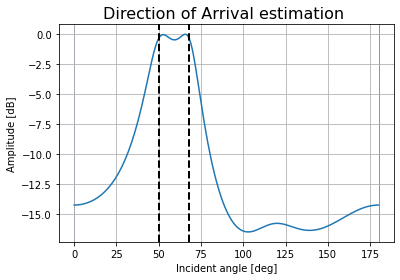

In [ ]:
d = 0.5 # Inter element spacing [lambda]
M = 10 # number of antenna elements in the antenna system (ULA)
M = 4 # temp value
N = 2**12  # sample size used for the simulation
N = 2**12 #MCV
theta1 = 50 # incident angle of the test signal [deg]
theta2 = 80 # incident angle of the test signal [deg]
# MCV temp
theta1, theta2 = 50, 68

# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))

a_90 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(90)))
a_0 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(0)))
a_60 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(60)))

# To display only the first fractional digit
np.set_printoptions(precision=1)

print("Signal is received from the front: a=",a_90)
print("Signal is received from the side: a=",a_0)
print("Signal is received on 60 deg: a=",a_60)

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))
print(f"Signal is received on {theta2} deg: a=",a_2)

# Generate multichannel test signal
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi1 = np.random.normal(0,1,N)  # Signal of Interest
correlated = False
if correlated:
  soi2 = soi1 #CAPON will faill here
else:
  print("not correlated")
  soi2 = np.random.normal(0,1,N)
#print(30,soi1)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

#soi_matrix  = ( np.outer( soi, a_1) + np.outer( soi, a_2)).T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)
#print(ula_scanning_vectors)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

# Get matplotlib axes object


# DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

DOA_plot(Capon, incident_angles, log_scale_min = -50)
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

### 2 elements
 does not seem to work ???

Minimum alias angle 0.00 
Maximum alias angle 0.00 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


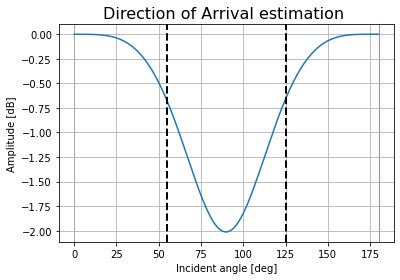

In [ ]:
M = 2 # number of antenna elements in the antenna system (ULA)
delta_theta = 35
theta1, theta2 = 90+delta_theta, 90-delta_theta

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi2 = np.random.normal(0,1,N)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

# DOA_plot(Capon, incident_angles, log_scale_min = -50)
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

### 3 elements

* BARTLET down to +/- 20 degree
* CAPON down to +/- 12 degree

Minimum alias angle 0.00 
Maximum alias angle 0.00 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


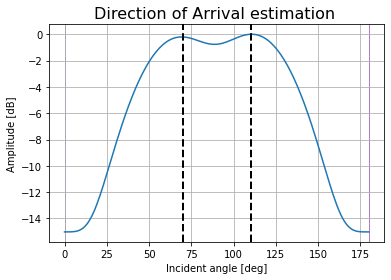

In [ ]:
M = 3 # number of antenna elements in the antenna system (ULA)
delta_theta = 20
theta1, theta2 = 90+delta_theta, 90-delta_theta

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi2 = np.random.normal(0,1,N)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

# DOA_plot(Capon, incident_angles, log_scale_min = -50)
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

### 4 elements

Bartlett +/- 13 degrees

Capon +/- 7 degrees

Minimum alias angle 0.00 
Maximum alias angle 0.00 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


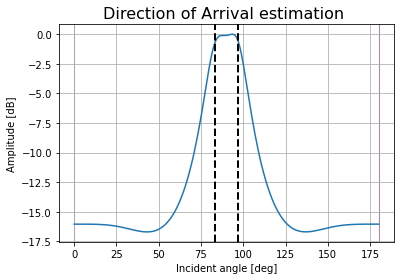

In [ ]:
M = 4 # number of antenna elements in the antenna system (ULA)
delta_theta = 7
theta1, theta2 = 90+delta_theta, 90-delta_theta

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi2 = np.random.normal(0,1,N)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

# DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

DOA_plot(Capon, incident_angles, log_scale_min = -50)
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

### 8 elements

* Bartlett +/- 7
* Capon +/- 3

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


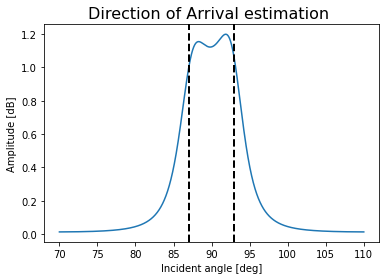

In [ ]:
d = 0.5 # Inter element spacing [lambda]
N = 2**12

M = 8 # number of antenna elements in the antenna system (ULA)
delta_theta = 3
theta1, theta2 = 90+delta_theta, 90-delta_theta

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
soi1 = np.random.normal(0,1,N)  # Signal of Interest
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi2 = np.random.normal(0,1,N)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles=None
incident_angles2= np.arange(70,110.01,0.01)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles2)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

# DOA_plot(Bartlett, incident_angles, log_scale_min = -50)
# DOA_plot(Capon, incident_angles2, log_scale_min = -50, alias_highlight=True)
fig = plt.figure()
axes  = fig.add_subplot(111)
axes.plot(incident_angles2,Capon)
axes.set_title('Direction of Arrival estimation ',fontsize = 16)
axes.set_xlabel('Incident angle [deg]')
axes.set_ylabel('Amplitude [dB]')
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

### 12 elements

* Bartlett: 4.2
* Capon: 1.7

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


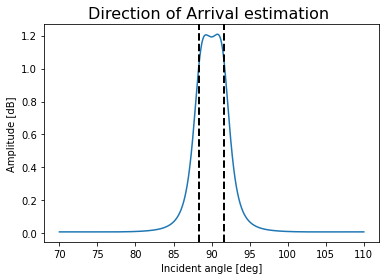

In [ ]:
d = 0.5 # Inter element spacing [lambda]
N = 2**12

M = 12 # number of antenna elements in the antenna system (ULA)
delta_theta = 1.7
theta1, theta2 = 90+delta_theta, 90-delta_theta

# Array response vectors of the test signal
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta1)))
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta2)))

# Generate multichannel test signal
soi1 = np.random.normal(0,1,N)  # Signal of Interest
# Notes seems to require some noise , if sigma is too low less reliable outcome?!?
soi2 = np.random.normal(0,1,N)
soi_outer = np.outer( soi1, a_1)
soi_outer+= np.outer( soi2, a_2)
soi_matrix= soi_outer.T

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

array_alignment = np.arange(0, M, 1)* d
incident_angles=None
incident_angles2= np.arange(70,110.01,0.01)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles2)

Bartlett = DOA_Bartlett(R,ula_scanning_vectors)
Capon = DOA_Capon(R, ula_scanning_vectors)

# DOA_plot(Bartlett, incident_angles, log_scale_min = -50)
# DOA_plot(Capon, incident_angles2, log_scale_min = -50, alias_highlight=True)
fig = plt.figure()
axes  = fig.add_subplot(111)
axes.plot(incident_angles2,Capon)
axes.set_title('Direction of Arrival estimation ',fontsize = 16)
axes.set_xlabel('Incident angle [deg]')
axes.set_ylabel('Amplitude [dB]')
# Mark nominal incident angles
axes = plt.axes()
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta2)

## angle of arrival with FFT

the phase increase as a function of distance between antennas and angle of arrival

$$ \omega = 2 \cdot \pi \cdot \lambda \cdot d \cdot sin(\theta)$$

Where:
* $ \lambda $ is the wavelength
* $ \theta $ is the angle of arrival (AoA)
* d is the distance between antennas

The AoA can be computed by looking for peaks in the FFT of the range FFT phase.

Similarly to temporal FFT, physical FFT defines:

* angular range bin, physical range bin is $ \frac{1}{d \cdot \frac{N}{2}} \iff $ angular range bin is $ \frac{2 \cdot \lambda *pi}{d \cdot N} = \frac{4*pi}{N}$
* angular resolution



tetha est [44.5633840657307, 19.098593171027442]


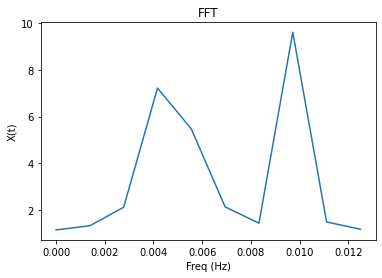

In [ ]:
"""X=arange(0,100,1e-2)
Y=sin(2*pi*10*X)
FA  = fmcw_fft(Y,X,1/1e-2,plot_fft=False)
FAt = fmcw_fft(Y,X,1/1e-2,plot_fft=True)
print(FA)"""

lambda1 = 0.05
d = lambda1 /2
Nrx = 20
X = arange(0.0, d*Nrx, d)
theta1=20
theta2 = 45
F1 = 1/lambda1*sin(theta1*pi/180)
F2 = 1/lambda1*sin(theta2*pi/180)

#ensure that there is at least one full period
assert F1*X[-1]>1
assert F2*X[-1]>1
#Y = sin(2*pi*F1*X)
Y = sin(2*pi*F1*X)+sin(2*pi*F2*X)
Fest=fmcw_fft(Y,X,1/d,plot_fft=False,Npeaks=2)
theta_est = [f1*lambda1*180/pi for f1 in Fest]
print("tetha est",theta_est)
F0=fmcw_fft(Y,X,d,plot_fft=True)


## angle of arrival with cross-correlation

background maths:
* https://www.eecs.umich.edu/courses/eecs206/archive/spring02/lab.dir/Lab3/lab3_v3_0_release.pdf

> p7/14 gives refresher of correlation of different sine waves to find frequencies

https://www.comm.utoronto.ca/~rsadve/Notes/DOA.pdf

> Fig 1. for different methods for spectral estimation and DoA

> Pcorr(φ) is a non-adaptive estimate of the spectrum of the incoming data. The M largest peaks of
this plot are the estimated directions of arrival.
In the case of our linear, equispaced array, the steering vector s(φ) is equivalent to Fourier
coefficients, i.e., the correlation in Eqn. (33) is equivalent to a DFT of the data vector x. We will
see that this technique is optimal (in the maximum likelihood sense) in the single user situation.

> ibid  `p6/25`

[45, 20, 44, 21]
20 45


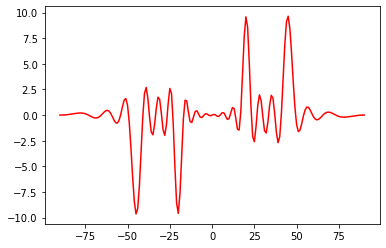

In [ ]:
corr = []
angles = range(-90,91,1)
for theta in angles:
  fc = 1/lambda1*sin(theta*pi/180)
  yc = sin(2*pi*fc*X)
  xcor = [yc[i]*Y[i] for i in range(len(X))]
  corr.append(sum(xcor))
f, ax1 = plt.subplots(num=1, clear=True)
ax1.plot(angles,corr,'-r')

top4 = sorted(corr,reverse=True)[:4]
angle4 = [angles[list(corr).index(peak)] for peak in top4]
print(angle4)
print(theta1,theta2)

## DFT

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline


def DFT(x):
    """
    Function to calculate the
    discrete Fourier Transform
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)

    X = np.dot(e, x)

    return X

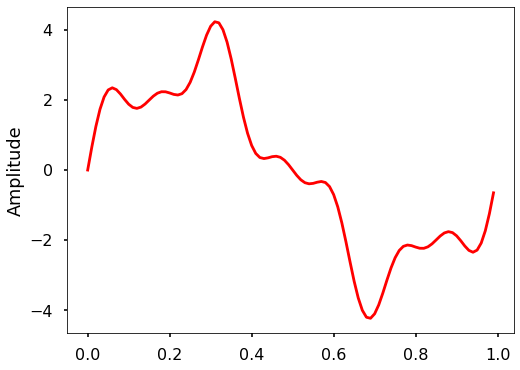

In [ ]:


# sampling rate
sr = 100
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

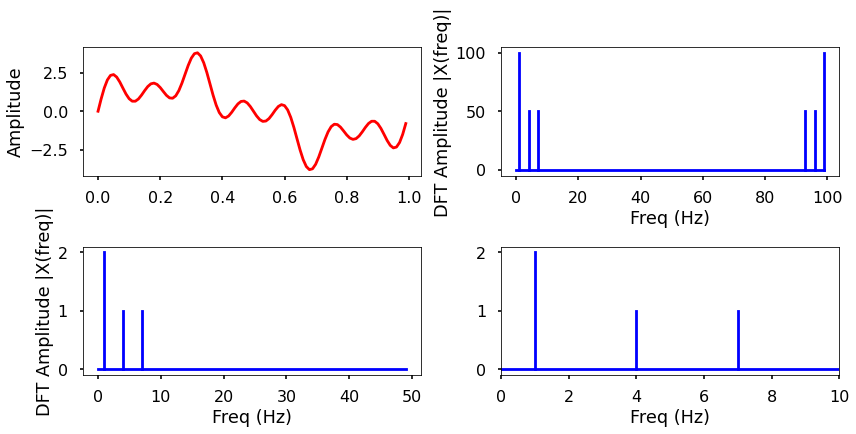

In [ ]:
freqs = [1,4,7]
x = np.sin(2*np.pi*freqs[0]*t)
for f in [1,4,7]:
  x+=np.sin(2*np.pi*f*t)

X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
#plt.figure(figsize = (8, 6))
plt.subplot(221)

plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.subplot(222)

plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside


plt.subplot(223)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(224)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 10)
plt.tight_layout()
#plt.show()

plt.show()

## AoA - MRE (old #2)

Below computes AoA for one target with 2 antennas, only looking at the phase difference

In [ ]:
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
from scipy.fft import fft

class Object(object):
    def __init__(self, x, y, z):
      self.x = x
      self.y = y
      self.z = z
    def dist(self, obj2):
      sx = self.x
      sy = self.y
      sz = self.z
      ox = obj2.x
      oy = obj2.y
      oz = obj2.z
      distance = sqrt((sx-ox)**2+(sy-oy)**2+(sz-oz)**2)
      return distance
    def __str__(self):
      return f"x: {self.x}, Y: {self.y}, z: {self.z}"

def y_IF(f0_min,slope,T, antenna_tx, antenna_rx, target):
  """ y_{IF} = cos(2 \pi [-f_0\delta -2 * K * \delta * t + K* \delta^2])
  delta: delta t = distance (m)/c
  A: (x,y,z)
  T: (x,y,z)
  """
  c = 3e8
  distance = antenna_tx.dist(target) + antenna_rx.dist(target)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/c
  # /!!!!!!\ most equations have 2 * delta as delta is the one way time of flight
  # here we have computed the 2 way round time of flight ence the lack of 2x
  # see text books ahve
  # YIF = cos(2 *pi *(2 * f0_min * delta + 2 * slope * delta * T + slope * delta**2))
  # but we only have :
  YIF = cos(2 *pi *(f0_min * delta + 2 * slope * delta * T + slope * delta**2))
  return YIF
f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 200e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = Object(-lambda0_max/2,0,0)
T = arange(0, n_samples*ts+ts, ts)

for theta in [-180/3, -180/6, -180/10, 0, 180/10, 180/6, 180/3]:
  Target = Object(4*tan(theta/180*pi),4,0)

  Antennas_RXs = [Object(i*lambda0_max/2,0,0) for i in range(n_rx)]

  phases = []
  i_peaks = []
  for target_i in [Target]:
    for antenna_rx in Antennas_RXs:
      Distance = antenna_rx.dist(target_i) + antenna_tx.dist(target_i)
      f_if = 2*k*Distance/c
      assert f_if < 1/ts/2
      YIF = y_IF(f0_min, k,T, antenna_tx, antenna_rx, target_i)
      FT = fft(YIF)
      MAG = abs(FT)[0:int(n_samples/2)]
      ANG = angle(FT)[0:int(n_samples/2)]

      # now find the peak
      amplitude_peak = sorted(MAG, reverse = True)[0]
      i_peak = list(MAG).index(amplitude_peak)
      if not i_peaks:
          i_peaks.append(i_peak)
      else:
          try:
              assert i_peak in i_peaks
          except:
            # exit now as we don't have the logic to track across range bins
              print("bin range change")
              break
      phases.append(ANG[0:int(n_samples/2)][i_peak])
      f_peak = i_peak * 1/ts / n_samples
      d2 = f_peak*c/2/k
      dfixed = 0

  delta_phase = (phases[0]-phases[1])  #/len(phases)
  # need to verify / proof below formula still seems buggy
  # idea is that phase goes inside frequency range bin and needs to be computed
  # as such
  # print("G***", 90+arcsin(delta_phase*1/ts*c/pi/ n_samples/1/k/lambda0_max)*180/pi)
  if delta_phase/pi>1:
    theta_calc = arcsin(delta_phase/pi -2)*180/pi
    print(f"theta: {theta:.2g}, calculated_p: {theta_calc:.2g}")
  elif delta_phase/pi<-1:
    theta_calc = arcsin(delta_phase/pi % +2)*180/pi
    print(f"theta: {theta:.2g}, calculated_m: {theta_calc:.2g}")
  else:
    theta_calc = arcsin(delta_phase/pi)*180/pi
    print(f"theta: {theta:.2g}, calculated: {theta_calc:.2g}")

theta: -60, calculated_p: -64
theta: -30, calculated: -31
theta: -18, calculated_p: -19
theta: 0, calculated: -0.019
theta: 18, calculated: 19
theta: 30, calculated: 31
theta: 60, calculated: 64


##  AoA trial #2

In [ ]:
#imports
from numpy import abs ,angle, arange, array, linspace, matrix, pi, sin, cos, exp
from numpy import sqrt, arcsin, arccos, arctan, dot, tan
from numpy import column_stack, identity
#import scipy.fftpack
from scipy.fftpack import fft, fftshift, fftfreq
import matplotlib.pyplot as plt

class Object(object):
    def __init__(self, x, y, z):
      self.x = x
      self.y = y
      self.z = z
    def dist(self, obj2):
      sx = self.x
      sy = self.y
      sz = self.z
      ox = obj2.x
      oy = obj2.y
      oz = obj2.z
      distance = sqrt((sx-ox)**2+(sy-oy)**2+(sz-oz)**2)
      return distance
    def __str__(self):
      return f"x: {self.x}, Y: {self.y}, z: {self.z}"

def y_IF(lambda0_max,slope,T, antenna_tx, antenna_rx, target):
  """ y_{IF} = cos(2 \pi [-f_0\delta -2 * K * \delta * t + K* \delta^2])
  delta: delta t = distance (m)/c
  A: (x,y,z)
  T: (x,y,z)
  """
  distance = antenna_RX.dist(target_i) + antenna_TX.dist(target_i)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/c
  f_0 = c/lambda0_max
  YIF = cos(2 *pi *(-f_0 *delta - 2 * slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 16
Distance = 10
k = 200e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

for Target_Angle in [-180/3, -180/6, -180/10, 0, 180/10, 180/6, 180/3]:
  print("Target Angle Objective", Target_Angle)
  Target = Object(4*tan(Target_Angle/180*pi),4,0)
  if abs(Target.x)>0:
    alpha = arctan(Target.y/Target.x)
  else:
    alpha = 0
  # theta = pi/2-alpha
  theta = None
  antenna_TX = Object(-lambda0_max/2,0,0)
  Antennas_RX = [Object(i*lambda0_max/2,0,0) for i in range(n_rx)]
  # ts = 1/f_if/n_samples
  # T = linspace(0.0, n_samples*ts+ts, n_samples)
  T = arange(0, n_samples*ts+ts, ts)
  phases = []
  Distances = []
  i_peaks = []
  for target_i in [Target]:
    for antenna_RX in Antennas_RX[:8]:
      Distance = antenna_RX.dist(target_i) + antenna_TX.dist(target_i)
      Distances.append(Distance)
      f_if = 2*k*Distance/c
      assert f_if < 1/ts/2
      YIF = y_IF(lambda0_max,k,T, antenna_TX, antenna_RX, target_i)
      FT = fft(YIF)
      MAG = abs(FT)[0:int(n_samples/2)]
      ANG = angle(FT)[0:int(n_samples/2)]

      # now find the peak
      amplitude_peak = sorted(MAG, reverse = True)[0]
      i_peak = list(MAG).index(amplitude_peak)
      if not i_peaks:
          i_peaks.append(i_peak)
      else:
          try:
              assert i_peak in i_peaks
          except:
            # exit now as we don't have the logic to track across range bins
              print("bin range change")
              break
      phases.append(ANG[0:int(n_samples/2)][i_peak])
      f_peak = i_peak * 1/ts / n_samples
      d2 = f_peak*c/2/k
      dfixed = 0

  delta_d = Distances[1]-Distances[0]
  delta_phase = (phases[0]-phases[1])  #/len(phases)
  # need to verify / proof below formula still seems buggy
  # idea is that phase goes inside frequency range bin and needs to be computed
  # as such
  # print("G***", 90+arcsin(delta_phase*1/ts*c/pi/ n_samples/1/k/lambda0_max)*180/pi)
  print("delta_phase",delta_phase/pi)
  if abs(delta_phase/pi)>1:
    print("ipeaks",i_peaks)
    print("test ?",arcsin(delta_phase/pi %1)*180/pi)
  else:
    theta_calc = arcsin(delta_phase/pi)*180/pi
    print("theta calc", theta_calc)


Target Angle Objective -60.0
delta_phase -0.8954859449632953
theta calc -63.57091626643821
Target Angle Objective -30.0
delta_phase 1.4814397586646584
ipeaks [126]
test ? 28.779477208424485
Target Angle Objective -18.0
delta_phase -0.3195709654583408
theta calc -18.636980685491228
Target Angle Objective 0
delta_phase -0.00032144728634370725
theta calc -0.018417573160603964
Target Angle Objective 18.0
delta_phase 0.31940018563514966
theta calc 18.626654540903953
Target Angle Objective 30.0
delta_phase 0.5153379636703278
theta calc 31.020047623162547
Target Angle Objective 60.0
delta_phase -1.1048598118773927
ipeaks [219]
test ? 63.52644220014059


In [ ]:
tx = Object(-lambda0_max/2,0,0)
rx0 = Object(0,0,0)
rx1 = Object(-lambda0_max/2,0,0)
angle = 30
angle = 0
D0 = 10
for angle in [0, 30]:
  theta = angle/180*pi
  target = Object(D0*tan(theta),D0,0)
  print(target)
  d1 = tx.dist(target)+rx0.dist(target)
  d2 = tx.dist(target)+rx1.dist(target)
  print(d2-d1,"///", lambda0_max/2*sin(theta),"@@",rx0.dist(target)-rx1.dist(target))

x: 0.0, Y: 10, z: 0
3.1249999565829967e-07 /// 0.0 @@ -3.1249999565829967e-07
x: 5.773502691896257, Y: 10, z: 0
0.001250202952732593 /// 0.0012499999999999998 @@ -0.001250202952732593


### Non linear FFT x-axis

16000.0 500


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


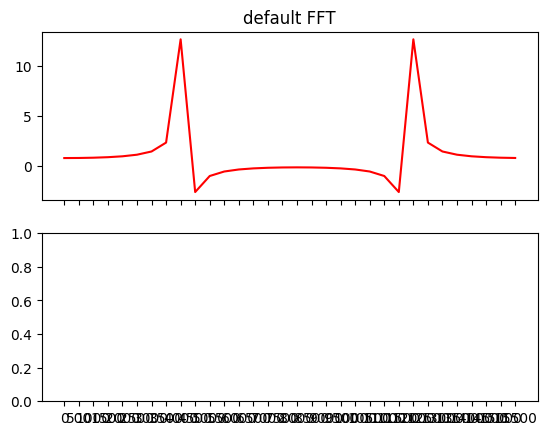

In [ ]:
from numpy import arange, cos, sin, pi
from scipy.fft import fft
import matplotlib.pyplot as plt

f0=500
f1 =4096
N = 32
ts = 1/f0/N
fs = 1/ts
assert fs> 2* f0
print(fs, f0)
T = arange(0, N*ts, ts)
y = cos(2*pi*f1*T)
DFT = fft(y)
F = arange(0, fs, fs/N)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.title.set_text(r"default FFT")
ax1.tick_params(axis='x', which='minor', bottom=False)
plt.xticks(F)
ax1.plot(F, DFT, 'r')